<a href="https://colab.research.google.com/github/nickchang001/Sentiment-Analysis-and-Topic-Modeling-on-User-Comments/blob/main/Sentiment_Analysis_and_Topic_Modeling_on_User_Comments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Youtube User Comments Analysis

In this project, we use NLP techniques such as LDA, word2vec and glove to analyze about 5.2M user comments (Unlabled data) from Youtube animal related channels. Base on the comments, we will attempt to identify if they are cat or dog ownser and find out the topic important to them. And identify the youtubers with most viewers that are cat or dog owners.

#Contents

* Part 0: Load data
* Part 1: Data Exploration and Cleaning



#Part 0: Set up Pyspark Environment And Load Data

In [ ]:
#install Pyspark
!apt-get update

#Download Java b/c spark is written in Scala language and require Java Virtual Mcahine (JVM) to run.
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

#Install spark 3.0.2 with Hadoop 2.7
!wget -q http://apache.forsale.plus/spark/spark-3.0.2/spark-3.0.2-bin-hadoop2.7.tgz
!tar xf spark-3.0.2-bin-hadoop2.7.tgz
!wget -q http://apache.mirrors.pair.com/spark/spark-3.0.2/spark-3.0.2-bin-hadoop2.7.tgz

#Insall findspark library which will locate Spark on system import it as regular library
!pip install -q findspark
!pip install py4j

!export JAVA_HOME=$(/usr/lib/jvm/java-8-openjdk-amd64 -v 1.8)
! echo $JAVA_HOME
#Set environment path. This will enable us to run Pyspark in the Colab environment.
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.2-bin-hadoop2.7"
import findspark
findspark.init("spark-3.0.2-bin-hadoop2.7")

#Install Pyspark
!pip install pyspark

# Install Sparknlp
!pip install --ignore-installed spark-nlp

from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [ ]:
import os

# Install java
! apt-get install -y openjdk-8-jdk-headless -qq > /dev/null
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["PATH"] = os.environ["JAVA_HOME"] + "/bin:" + os.environ["PATH"]
! java -version

# Install pyspark
! pip install --ignore-installed pyspark==2.4.7

# Install Spark NLP
! pip install --ignore-installed spark-nlp==2.7.4

# Quick SparkSession start
import sparknlp
spark = sparknlp.start()

print("Spark NLP version")
sparknlp.version()
print("Apache Spark version")
spark.version

openjdk version "1.8.0_282"
OpenJDK Runtime Environment (build 1.8.0_282-8u282-b08-0ubuntu1~18.04-b08)
OpenJDK 64-Bit Server VM (build 25.282-b08, mixed mode)
     |████████████████████████████████| 217.9MB 60kB/s 
     |████████████████████████████████| 204kB 23.5MB/s 
  Created wheel for pyspark: filename=pyspark-2.4.7-py2.py3-none-any.whl size=218279465 sha256=5fef4f5ca69844fca80d1f9a458e304d51761fa4238206b584e8f0bff3a1c5ac
  Stored in directory: /root/.cache/pip/wheels/34/1f/2e/1e7460f80acf26b08dbb8c53d7ff9e07146f2a68dd5c732be5
Successfully built pyspark
     |████████████████████████████████| 143kB 19.1MB/s 
Spark NLP version
Apache Spark version


'2.4.7'

In [ ]:
#import nessary packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import json
from pyspark.ml import Pipeline
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from sparknlp.annotator import *
from sparknlp.base import *
import sparknlp

In [ ]:
from sparknlp.base import *
from pyspark.ml.feature import StopWordsRemover
from pyspark.ml.feature import RegexTokenizer
from pyspark.sql.functions import col, udf
from pyspark.ml.feature import RegexTokenizer

In [ ]:
spark = sparknlp.start()
sparknlp.start(gpu=True)
print("Spark NLP version: ", sparknlp.version())
print("Apache Spark version: ", spark.version)

Spark NLP version:  2.7.4
Apache Spark version:  2.4.7


In [ ]:
#uninstall pyarrow and install it latter inorder to fix the issue of importing koalas
!pip uninstall pyarrow

#install Koalas
!pip install koalas

# Install compatible version of pyarrow
!pip install pyarrow

#import koalas package
import databricks.koalas as ks

Uninstalling pyarrow-3.0.0:
  Would remove:
    /usr/local/bin/plasma_store
    /usr/local/lib/python3.7/dist-packages/pyarrow-3.0.0.dist-info/*
    /usr/local/lib/python3.7/dist-packages/pyarrow/*
Proceed (y/n)? y
  Successfully uninstalled pyarrow-3.0.0
     |████████████████████████████████| 675kB 5.0MB/s 
     |████████████████████████████████| 20.7MB 44.7MB/s 


###Load and cache data

In [ ]:
#load data from google drive 
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


In [ ]:
file = r'/gdrive/MyDrive/Projects/NLP_Youtube_reviews/animals_comments.csv'
full_reviews_df = spark.read.csv(file, header=True, inferSchema=True) 
full_reviews_df.cache()
full_reviews_df.show()

+--------------------+------+-------------------------------------+
|        creator_name|userid|                              comment|
+--------------------+------+-------------------------------------+
|        Doug The Pug|  87.0|                 I shared this to ...|
|        Doug The Pug|  87.0|                   Super cute  😀🐕🐶|
|         bulletproof| 530.0|                 stop saying get e...|
|       Meu Zoológico| 670.0|                 Tenho uma jiboia ...|
|              ojatro|1031.0|                 I wanna see what ...|
|     Tingle Triggers|1212.0|                 Well shit now Im ...|
|Hope For Paws - O...|1806.0|                 when I saw the en...|
|Hope For Paws - O...|2036.0|                 Holy crap. That i...|
|          Life Story|2637.0|武器はクエストで貰えるんじゃないん...|
|       Brian Barczyk|2698.0|                 Call the teddy Larry|
|            The Dodo|2702.0|                   😐🤔😓😢😭😭😭😭😟|
|Hope For Paws - O...|2911.0|                 That mother cat l...|
|Hope For

#Part 1: Explotary Data Analysis (EDA) 

In [ ]:
#check column's datatypes
full_reviews_df.dtypes

[('creator_name', 'string'), ('userid', 'double'), ('comment', 'string')]

In [ ]:
num_rows = full_reviews_df.count()
print('Number of rows in df:', num_rows)

Number of rows in df: 5820035


In [ ]:
#Check distict creator and user
print('Total number of distinct creator_name:{} (out of totoal creater_name:{}).'.format(full_reviews_df.select('creator_name').distinct().count(),num_rows))
print('Total number of distinct userid:{} (out of totoal userid:{}).'.format(full_reviews_df.select('userid').distinct().count(), num_rows))


Total number of distinct creator_name:4241 (out of totoal creater_name:5820035).
Total number of distinct userid:2537174 (out of totoal userid:5820035).


Notes: There are 4241 creators and 2.5M different users.

In [ ]:
#Check if any null values and count
print('Number of null values in creator_name:', full_reviews_df.filter(full_reviews_df['creator_name'].isNull()).count())
print('Number of null values in userid: ',full_reviews_df.filter(full_reviews_df['userid'].isNull()).count())
print('Number of null values in comment: ',full_reviews_df.filter(full_reviews_df['comment'].isNull()).count())

Number of null values in creator_name: 32050
Number of null values in userid:  565
Number of null values in comment:  1051


Notes: There are some missing values. Creator_name has 32k missing.

In [ ]:
from pyspark.sql.functions import *

In [ ]:
#Count number of reviews that each creator recieved
group_by_creator = full_reviews_df.groupBy('creator_name').count().withColumnRenamed('count', 'num_comments').orderBy(col('num_comments').desc())
group_by_creator.show()

+-----------------------+------------+
|           creator_name|num_comments|
+-----------------------+------------+
|       Brave Wilderness|     1048751|
|          Brian Barczyk|      386324|
|               The Dodo|      325071|
|     Taylor Nicole Dean|      235644|
|   Hope For Paws - O...|      127731|
|            Info Marvel|      121353|
|           Robin Seplut|      116551|
|꼬부기아빠 My Pet Diary|      102594|
|              Vet Ranch|      102127|
|        Gohan The Husky|       99580|
|               ViralHog|       87939|
|        Viktor Larkhill|       76341|
|      Talking Kitty Cat|       74315|
|    Keedes channel LIVE|       72829|
|              MonkeyBoo|       70173|
|               Mạnh CFM|       64826|
|   Gone to the Snow ...|       55244|
|           Mr. Max T.V.|       51365|
|       Cole & Marmalade|       50422|
|     Think Like A Horse|       48877|
+-----------------------+------------+
only showing top 20 rows



In [ ]:
#Show number if reviews that each user gave
group_by_userid = full_reviews_df.groupBy('userid').count().withColumnRenamed('count', 'num_comments').orderBy(col('num_comments').desc())
group_by_userid.show()

+---------+------------+
|   userid|num_comments|
+---------+------------+
|2036522.0|        2571|
| 455571.0|        2159|
| 569313.0|        1452|
|1727704.0|        1339|
|2041593.0|        1288|
|2288680.0|        1247|
| 954873.0|         888|
| 479268.0|         775|
|1568280.0|         757|
| 575285.0|         742|
|2184324.0|         740|
| 170012.0|         725|
| 797741.0|         697|
|1367232.0|         671|
|1293328.0|         644|
|2056517.0|         642|
|1705977.0|         627|
|2071628.0|         605|
|1448539.0|         601|
| 717385.0|         596|
+---------+------------+
only showing top 20 rows



In [ ]:
print('For the users that rated videos and the channel that were rated:')
print('Maximun number of reviews per userid: {}'.format(full_reviews_df.groupBy('userid').count().select('count').rdd.max()[0]))
print('Maximun number of reviews per Youtube Channel (creator_name): {}'.format(full_reviews_df.groupBy('creator_name').count().select('count').rdd.max()[0]))

For the users that rated videos and the channel that were rated:
Maximun number of reviews per userid: 2571
Maximun number of reviews per Youtube Channel (creator_name): 1048751


#Part 2: Build ML Pipeline And Data Preprocessing



1.   Remove null values.
2.   Create label for dog and cat comments.
3.   High imbalance datast: Down Sampling.

4.    ML Pipeline: Tockenization, Removing stop wrod, Stemming, Word2Vec



**Try 10% of sample dataset.**

In [ ]:
#split data into smaller sample
#reviews_df, reviews9_df= full_reviews_df.randomSplit([0.1, 0.9])
#print('Sample data size: ', reviews_df.count())

###Part 2.1: Drop Null Values

In [ ]:
#drop null value in creator_name, userid and comments, and drop duplicates
#since spark dataframe is immutable, so we will create a new datafram without null values
def pre_process(df):
  for colume in df.columns:
    df=df.filter(df[colume].isNotNull())

  #drop duplicate
  clean_reviews_df = df.dropDuplicates() #return a new datafram with duplicate row removed
  
  print('After droppoing, we have {} rows in dataframe'.format(clean_reviews_df.count()))
  return clean_reviews_df


clean_reviews_df = pre_process(full_reviews_df)

#cache the dataframe
clean_reviews_df.cache()

After droppoing, we have 5725602 rows in dataframe


DataFrame[creator_name: string, userid: double, comment: string]

###Part2.2: Create Label For Users Who have Dog And Cat 

**This is an unlabeled dataset and we want to train a clasifier to identify cat and dog owners. Thus first thing to do is to label each comment.**

1. Label comment when 
he/she has dogs or cats.
2. label comment when he/she don't have a dog or cat.
3. Combine 1 and 2 as our training dataset, and rest of the dataset will be the data we predict.
4. The strategy to tell if a user own or not own is just using key words (like I have a dog) to tell. Otherwise we can't have better ways and don't have labels.

In [ ]:
#label user with preference of dog and cat
from pyspark.sql.types import IntegerType

cond = (clean_reviews_df["comment"].like("%my dog%") | clean_reviews_df["comment"].like("%I have a dog%") | clean_reviews_df["comment"].like("%my dogs%") | clean_reviews_df["comment"].like("%I have dog%")
        | clean_reviews_df["comment"].like("%my cat%") | clean_reviews_df["comment"].like("%my cats%") | clean_reviews_df["comment"].like("%I have a cat%") | clean_reviews_df["comment"].like("%I have cat%") 
        | clean_reviews_df["comment"].like("%my puppy%") | clean_reviews_df["comment"].like("%my puppies%") | clean_reviews_df["comment"].like("%my kitty%") | clean_reviews_df["comment"].like("%my kitties%") 
        | clean_reviews_df["comment"].like("%I have a kitty%") | clean_reviews_df["comment"].like("%I have kitties%") | clean_reviews_df["comment"].like("%I have a puppy%") | clean_reviews_df["comment"].like("%I have puppies%"))

labeled_reviews_df = clean_reviews_df.withColumn('dog_cat',  cond)

# label user who do not have pet
labeled_reviews_df = labeled_reviews_df.withColumn('no_pet', ~labeled_reviews_df["comment"].like("%my%") & ~labeled_reviews_df["comment"].like("%have%") 
                                                  & ~labeled_reviews_df['comment'].like('%my dog%') & ~labeled_reviews_df['comment'].like('%my cat%'))

#create a label column, comment categorized as dog_cat=1 else 0
labeled_reviews_df = labeled_reviews_df.withColumn('label', col('dog_cat').cast(IntegerType()).cast('double'))

#filter comments with pet and not_pet, then combine them as an new dataframe
#Since we are Only interested in the user who has dog and cat, so we choose the comment from
#dog and cat user as positive label and the comments which classified as no pet as Negative lables.
pet = labeled_reviews_df.filter(col('dog_cat')==True)
no_pet = labeled_reviews_df.filter(col('no_pet')==True)
pet_df = pet.union(no_pet)

pet_df.cache()
pet_df.show()

+--------------------+---------+--------------------+-------+------+-----+
|        creator_name|   userid|             comment|dog_cat|no_pet|label|
+--------------------+---------+--------------------+-------+------+-----+
|    Cole & Marmalade| 846766.0|I like to sing in...|   true| false|  1.0|
|     MARLENE MCCOHEN|2225630.0|hey my dogs racis...|   true| false|  1.0|
|               Maymo|2476023.0|This is my dog in...|   true| false|  1.0|
|           Bully Max| 954499.0|Thats why I adopt...|   true| false|  1.0|
|     Viktor Larkhill| 942806.0|Teddy you are in ...|   true| false|  1.0|
|           GoHerping|1766617.0|just got one and ...|   true| false|  1.0|
|       Brian Barczyk|2351519.0|I feel you my dog...|   true| false|  1.0|
|       Brian Barczyk| 124380.0|Arty will get bet...|   true| false|  1.0|
|            Gardea23|1656838.0|i wish i could pl...|   true| false|  1.0|
|     Gohan The Husky| 967274.0|I gave this type ...|   true| false|  1.0|
|          Funny Pets|175

In [ ]:
num_pet = pet.count()
num_no_pet = no_pet.count()
num_sample = pet_df.count()
true_label_pct = num_pet/num_sample*100
print('There are {} of comments are classified as dog or cat owners in {} ({:.2f}%) of total comments.'.format(num_pet, num_sample, true_label_pct))

There are 40180 of comments are classified as dog or cat owners in 4902747 (0.82%) of total comments.


***Note: very high imbalance label with less than 1% of users have dog or cat over total comments. ***

**Down sampling:
the no_pet because 

*   Dowsampling the data is extremely imbalance. We just use downsampling technique because spark did't support SMOTE
*   **Only downsampling on training dataset**, and keep the test data as original.


###Split Data Into Train and Test

In [ ]:
#train test split with 80% taining, 20% test
training, test = pet_df.randomSplit([0.8, 0.2])
training.cache()
test.cache()

DataFrame[creator_name: string, userid: double, comment: string, dog_cat: boolean, no_pet: boolean, label: double]

In [ ]:
training.show()

+------------------+---------+--------------------+-------+------+-----+
|      creator_name|   userid|             comment|dog_cat|no_pet|label|
+------------------+---------+--------------------+-------+------+-----+
|    Aarons Animals|2285699.0|Never gonna happe...|   true| false|  1.0|
|Alex Knappenberger| 517292.0|Kid thinks he is ...|   true| false|  1.0|
|  Brave Wilderness| 212789.0|The crab is cuter...|   true| false|  1.0|
|  Brave Wilderness| 805828.0|4:30 Sounds like ...|   true| false|  1.0|
|  Brave Wilderness|1008240.0|Omg it’s so adora...|   true| false|  1.0|
|     Brian Barczyk|  33429.0|Im crying along w...|   true| false|  1.0|
|     Brian Barczyk| 124380.0|Arty will get bet...|   true| false|  1.0|
|     Brian Barczyk| 410371.0|that happend to m...|   true| false|  1.0|
|     Brian Barczyk|1564810.0|Hey my dog is 4 y...|   true| false|  1.0|
|     Brian Barczyk|1766603.0|Im really crying ...|   true| false|  1.0|
|     Brian Barczyk|1996262.0|Number 5 because ...|

In [ ]:
#down sampling the no_pet only on training dataset
#filter taining data into pet and no_pet dataframe
training_pet = training.filter(training['label']==1.0)
training_no_pet = training.filter(training['label']==0.0)

#get ratio b/t pet and no_pet sample, we choose pet and no_pet ratio to be 2:1.
sampleRatio = float(num_pet) / float(num_no_pet)*2

#down sample no_pet on training dataset
sample_training_no_pet = training_no_pet.sample(withReplacement=False, fraction=sampleRatio)

#build a new datafrom with combining pet and sample no_pet on training data
sample_training_df = training_pet.union(sample_training_no_pet)
sample_training_df.show()

+------------------+---------+--------------------+-------+------+-----+
|      creator_name|   userid|             comment|dog_cat|no_pet|label|
+------------------+---------+--------------------+-------+------+-----+
|    Aarons Animals|2285699.0|Never gonna happe...|   true| false|  1.0|
|Alex Knappenberger| 517292.0|Kid thinks he is ...|   true| false|  1.0|
|  Brave Wilderness| 212789.0|The crab is cuter...|   true| false|  1.0|
|  Brave Wilderness| 805828.0|4:30 Sounds like ...|   true| false|  1.0|
|  Brave Wilderness|1008240.0|Omg it’s so adora...|   true| false|  1.0|
|     Brian Barczyk|  33429.0|Im crying along w...|   true| false|  1.0|
|     Brian Barczyk| 124380.0|Arty will get bet...|   true| false|  1.0|
|     Brian Barczyk| 410371.0|that happend to m...|   true| false|  1.0|
|     Brian Barczyk|1564810.0|Hey my dog is 4 y...|   true| false|  1.0|
|     Brian Barczyk|1766603.0|Im really crying ...|   true| false|  1.0|
|     Brian Barczyk|1996262.0|Number 5 because ...|

In [ ]:
sample_training_df.toPandas().to_csv('/gdrive/MyDrive/Projects/NLP_Youtube_reviews/sample_training.csv')
test.toPandas().to_csv('/gdrive/MyDrive/Projects/NLP_Youtube_reviews/test.csv')

In [ ]:
sample_train_df = spark.read.csv('/gdrive/MyDrive/Projects/NLP_Youtube_reviews/sample_training.csv', header=True)
sample_train_df.cache()
sample_train_df.show()

+---+------------------+---------+--------------------+-------+------+-----+
|_c0|      creator_name|   userid|             comment|dog_cat|no_pet|label|
+---+------------------+---------+--------------------+-------+------+-----+
|  0|    Aarons Animals|2285699.0|Never gonna happe...|   True| False|  1.0|
|  1|Alex Knappenberger| 517292.0|Kid thinks he is ...|   True| False|  1.0|
|  2|  Brave Wilderness| 212789.0|The crab is cuter...|   True| False|  1.0|
|  3|  Brave Wilderness| 805828.0|4:30 Sounds like ...|   True| False|  1.0|
|  4|  Brave Wilderness|1008240.0|Omg it’s so adora...|   True| False|  1.0|
|  5|     Brian Barczyk|  33429.0|Im crying along w...|   True| False|  1.0|
|  6|     Brian Barczyk| 124380.0|Arty will get bet...|   True| False|  1.0|
|  7|     Brian Barczyk| 410371.0|that happend to m...|   True| False|  1.0|
|  8|     Brian Barczyk|1564810.0|Hey my dog is 4 y...|   True| False|  1.0|
|  9|     Brian Barczyk|1766603.0|Im really crying ...|   True| False|  1.0|

In [ ]:
test = spark.read.csv('/gdrive/MyDrive/Projects/NLP_Youtube_reviews/test.csv', header=True)
test.show()

+---+--------------------+---------+--------------------+-------+------+-----+
|_c0|        creator_name|   userid|             comment|dog_cat|no_pet|label|
+---+--------------------+---------+--------------------+-------+------+-----+
|  0|       Brian Barczyk| 458191.0|I totally know ho...|   True| False|  1.0|
|  1|       Brian Barczyk| 894048.0|I feel bad for yo...|   True| False|  1.0|
|  2|       Brian Barczyk|1772442.0|I wish I could vi...|   True| False|  1.0|
|  3|    Cole & Marmalade| 846766.0|I like to sing in...|   True| False|  1.0|
|  4|    Cole & Marmalade|1174029.0|Aww! They remind ...|   True| False|  1.0|
|  5|    Cole & Marmalade|2070940.0|a woman came into...|   True| False|  1.0|
|  6|    Cole & Marmalade|2361207.0|I miss my cats pu...|   True| False|  1.0|
|  7|Dog Training by K...|1533459.0|I was doing ok un...|   True| False|  1.0|
|  8|          Funny Pets| 985616.0|One time I had a ...|   True| False|  1.0|
|  9|          Funny Pets|1755054.0|I wana go hug my

In [ ]:
sample_train_df.count()

96229

In [ ]:
sample_train1 = sample_train_df

###Build a Pipeline to preprocess the text data/Embedding

In [ ]:
from sparknlp.base import *
from sparknlp.annotator import *

In [ ]:
#Step0:DocumentAssembler to prepare our doc such as cleans up source text 
#and handes special charactoers and ner line thourgh 'cleanupMode'
document = DocumentAssembler().setInputCol('comment').setOutputCol('document').setCleanupMode('shrink')

#Step2: sentence detector
#explode sentences imporves parallelism in large text concentration
sentence = SentenceDetector().setInputCols(['document']).setOutputCol('sentences')

#Step3: tokenize
tokenize = Tokenizer().setInputCols(['sentences']).setOutputCol('token')

#Step4:Nomalizer
normalize = Normalizer().setInputCols(['token']).setOutputCol('normal').setLowercase(True)

#step5: Spell checkers: SymmetircDetele or NorvigSweeting: Fix token typo
#pretrained() function on AnnotatorModels retreive free open source pretrained models
checker = NorvigSweetingModel.pretrained().setInputCols(['normal']).setOutputCol('checked')

#Stage6: Stemmer
stem = Stemmer().setInputCols(['checked']).setOutputCol('stem')

#Step6:SotpwordsCleaner
stop_words_cleaner = StopWordsCleaner().setInputCols(['stem']).setOutputCol('clean_token')

#Word embedding using BERT
#bert = BertEmbeddings.pretrained('bert_base_cased', 'en').setInputCols(['document','clean_token']).setOutputCol('bert_embedding').setLazyAnnotator(False).setDimension(5)

#Bert Sentence Embedding
bert_sent = BertSentenceEmbeddings().pretrained()\
    .setInputCols(['sentences'])\
    .setOutputCol('bert_sentence').setLazyAnnotator(False).setDimension(5)


nlpPipeline = Pipeline().setStages([document, sentence, tokenize, normalize, checker, \
                                  stem, stop_words_cleaner, bert_sent, classifier])


sent_small_bert_L2_768 download started this may take some time.
Approximate size to download 139.6 MB
[OK!]
sentimentdl_use_twitter download started this may take some time.
Approximate size to download 11.4 MB
[OK!]


In [ ]:
transformed_df = nlpPipeline.fit(sample_train_df).transform(sample_train_df)

In [ ]:
transformed_df.printSchema()

root
 |-- _c0: string (nullable = true)
 |-- creator_name: string (nullable = true)
 |-- userid: string (nullable = true)
 |-- comment: string (nullable = true)
 |-- dog_cat: string (nullable = true)
 |-- no_pet: string (nullable = true)
 |-- label: string (nullable = true)
 |-- document: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- annotatorType: string (nullable = true)
 |    |    |-- begin: integer (nullable = false)
 |    |    |-- end: integer (nullable = false)
 |    |    |-- result: string (nullable = true)
 |    |    |-- metadata: map (nullable = true)
 |    |    |    |-- key: string
 |    |    |    |-- value: string (valueContainsNull = true)
 |    |    |-- embeddings: array (nullable = true)
 |    |    |    |-- element: float (containsNull = false)
 |-- sentences: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- annotatorType: string (nullable = true)
 |    |    |-- begin: integer (nullable = false

In [ ]:
transformed_df.select('bert_sentence.embeddings').show()

+--------------------+
|          embeddings|
+--------------------+
|[[0.46289614, -0....|
|[[0.17598966, -0....|
|[[0.12013, 0.0246...|
|[[0.23815076, -0....|
|[[0.43891796, -0....|
|[[0.201562, -0.19...|
|[[0.09835973, -0....|
|[[0.2889648, -0.0...|
|[[-0.18898217, 0....|
|[[0.2697565, 0.00...|
|[[0.003601325, 0....|
|[[0.04141036, 0.0...|
|[[0.28889224, 0.1...|
|[[0.090274066, -0...|
|[[-0.13652015, 0....|
|[[-0.18248558, -0...|
|[[0.34743783, 0.2...|
|[[0.16330938, 0.0...|
|[[0.029585354, 0....|
|[[0.41166124, 0.1...|
+--------------------+
only showing top 20 rows



In [ ]:
emb_vector = np.array(transformed_df.select('bert_sentence.embeddings').take(1))
emb_vector

array([[[[ 4.62896138e-01, -2.25370213e-01,  1.02745183e-02,
          -2.76800573e-01,  1.09414428e-01, -1.06401123e-01,
           2.39372656e-01, -1.92180827e-01, -8.66874531e-02,
          -1.86135992e-01,  3.69453847e-01,  2.80574188e-02,
           3.65240991e-01,  2.06813768e-01,  3.56744826e-01,
           5.14788777e-02, -2.93423664e-02,  3.55112165e-01,
          -2.24962011e-01, -4.34143618e-02,  1.80959925e-01,
           4.59852554e-02,  3.25410694e-01, -1.74582332e-01,
           5.37889600e-02, -3.50600541e-01,  4.43296246e-02,
           2.95121789e-01,  3.61517727e-01,  2.75462806e-01,
          -1.75614674e-02, -3.61944616e-01, -7.44296163e-02,
          -4.00695294e-01, -4.45494682e-01,  4.84888330e-02,
          -2.58534223e-01, -6.00887761e-02, -2.20682584e-02,
          -4.23685387e-02, -1.02630835e-02,  4.14224744e-01,
          -2.64162421e-02, -8.89469832e-02, -4.63407440e-03,
           1.57435417e-01, -1.01722606e-01,  5.61416984e-01,
           1.15713142e-0

###Build a Pipeline for Sentiment Analysis

In [ ]:
documentAssembler = DocumentAssembler()\
    .setInputCol("comment")\
    .setOutputCol("document")
    
use = UniversalSentenceEncoder.pretrained(name="tfhub_use", lang="en")\
 .setInputCols(["document"])\
 .setOutputCol("sentence_embeddings")


sentimentdl = SentimentDLModel.pretrained(name='sentimentdl_use_twitter', lang="en")\
    .setInputCols(["sentence_embeddings"])\
    .setOutputCol("sentiment")

sentimentPipeline = Pipeline(
      stages = [
          documentAssembler,
          use,
          sentimentdl
      ])

In [ ]:
result = sentimentPipeline.fit(sample_train_df).transform(sample_train_df)

In [ ]:
result.select(['label','sentiment']).show(truncate=False)

+-----+----------------------------------------------------------------------------------------------------+
|label|sentiment                                                                                           |
+-----+----------------------------------------------------------------------------------------------------+
|1.0  |[[category, 0, 67, negative, [sentence -> 0, positive -> 0.39856157, negative -> 0.6014384], []]]   |
|1.0  |[[category, 0, 194, negative, [sentence -> 0, positive -> 0.0014285817, negative -> 0.9985714], []]]|
|1.0  |[[category, 0, 127, neutral, [sentence -> 0, positive -> 0.5587931, negative -> 0.4412069], []]]    |
|1.0  |[[category, 0, 22, positive, [sentence -> 0, positive -> 1.0, negative -> 1.3994341E-21], []]]      |
|1.0  |[[category, 0, 41, positive, [sentence -> 0, positive -> 1.0, negative -> 0.0], []]]                |
|1.0  |[[category, 0, 194, negative, [sentence -> 0, positive -> 2.5638668E-8, negative -> 1.0], []]]      |
|1.0  |[[category, 

###Word Embedding by sparkml

In [ ]:
 from sparknlp.base import *
from pyspark.ml.feature import StopWordsRemover
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, Word2Vec
from pyspark.ml import Pipeline
from pyspark.sql.functions import col, udf


#Create feature transformers
#Regular expression tokenizer; break sentence into individual term base on regular expression
regexpTokenizer = RegexTokenizer(inputCol='comment', outputCol='words', pattern='\\W', toLowercase=True)

#Stop words removing, such as i, a, the...,etc.
remover = StopWordsRemover(inputCol="words", outputCol="filtered")

#Construct a pipeline
pipeline = Pipeline(stages = [regexpTokenizer, remover])

#Fit and Transform data
pipelineModel = pipeline.fit(sample_training_df)
clean_training_df = pipelineModel.transform(sample_training_df)
clean_test_df = pipelineModel.transform(test)
clean_training_df.cache()
clean_test_df.cache()
clean_training_df.show()

+------------------+---------+--------------------+-------+------+-----+--------------------+--------------------+
|      creator_name|   userid|             comment|dog_cat|no_pet|label|               words|            filtered|
+------------------+---------+--------------------+-------+------+-----+--------------------+--------------------+
|    Aarons Animals|2285699.0|Never gonna happe...|   true| false|  1.0|[never, gonna, ha...|[never, gonna, ha...|
|Alex Knappenberger| 517292.0|Kid thinks he is ...|   true| false|  1.0|[kid, thinks, he,...|[kid, thinks, coo...|
|  Brave Wilderness| 212789.0|The crab is cuter...|   true| false|  1.0|[the, crab, is, c...|[crab, cuter, dog...|
|  Brave Wilderness|1008240.0|Omg it’s so adora...|   true| false|  1.0|[omg, it, s, so, ...|[omg, adorable, s...|
|     Brian Barczyk|  33429.0|Im crying along w...|   true| false|  1.0|[im, crying, alon...|[im, crying, alon...|
|     Brian Barczyk| 124380.0|Arty will get bet...|   true| false|  1.0|[arty, w

**Build a stem function from scratch and CountVectorizer**

In [ ]:
#built a stmmer function b/c spark ml didn't support
from nltk.stem.porter import *
from pyspark.ml.feature import CountVectorizer, CountVectorizerModel

# Instantiate stemmer object
stemmer = PorterStemmer()

# Create stemmer python function
def stem(words):
    out_words = []
    for word in words:
        stem_word = stemmer.stem(word)
        if len(stem_word) > 2:
            out_words.append(stem_word)       
    return out_words

# Create user defined function for stemming with return type Array<String>
from pyspark.sql.types import *
stemmer_udf = udf(lambda x: stem(x), ArrayType(StringType())) #iterate each row as input for function stem

# Create new column with vectors containing the stemmed tokens 
clean_training_df = clean_training_df.withColumn("stem_comment", stemmer_udf("filtered"))
clean_test_df = clean_test_df.withColumn("stem_comment", stemmer_udf("filtered"))

clean_training_df.cache()
clean_test_df.cache()
clean_training_df.show()

+----------------+---------+--------------------+-------+------+-----+--------------------+--------------------+--------------------+
|    creator_name|   userid|             comment|dog_cat|no_pet|label|               words|            filtered|        stem_comment|
+----------------+---------+--------------------+-------+------+-----+--------------------+--------------------+--------------------+
|  Aarons Animals|2285699.0|Never gonna happe...|   true| false|  1.0|[never, gonna, ha...|[never, gonna, ha...|[never, gonna, ha...|
|Brave Wilderness| 212789.0|The crab is cuter...|   true| false|  1.0|[the, crab, is, c...|[crab, cuter, dog...|[crab, cuter, dog...|
|Brave Wilderness|1008240.0|Omg it’s so adora...|   true| false|  1.0|[omg, it, s, so, ...|[omg, adorable, s...|[omg, ador, sound...|
|   Brian Barczyk|  33429.0|Im crying along w...|   true| false|  1.0|[im, crying, alon...|[im, crying, alon...|[cri, along, dog,...|
|   Brian Barczyk| 124380.0|Arty will get bet...|   true| fals

In [ ]:
#Word2vec
word2Vec = Word2Vec(inputCol='stem_comment', outputCol='word2vec')
word2vec_model = word2Vec.fit(clean_training_df)
w2v_training_df = word2vec_model.transform(clean_training_df)
w2v_test_df = word2vec_model.transform(clean_test_df)

#cache data
w2v_training_df.cache()
w2v_test_df.cache()
w2v_training_df.show()

+----------------+---------+--------------------+-------+------+-----+--------------------+--------------------+--------------------+--------------------+
|    creator_name|   userid|             comment|dog_cat|no_pet|label|               words|            filtered|        stem_comment|            word2vec|
+----------------+---------+--------------------+-------+------+-----+--------------------+--------------------+--------------------+--------------------+
|  Aarons Animals|2285699.0|Never gonna happe...|   true| false|  1.0|[never, gonna, ha...|[never, gonna, ha...|[never, gonna, ha...|[0.05999122526554...|
|Brave Wilderness| 212789.0|The crab is cuter...|   true| false|  1.0|[the, crab, is, c...|[crab, cuter, dog...|[crab, cuter, dog...|[0.00284937682694...|
|Brave Wilderness|1008240.0|Omg it’s so adora...|   true| false|  1.0|[omg, it, s, so, ...|[omg, adorable, s...|[omg, ador, sound...|[0.01973844617605...|
|   Brian Barczyk|  33429.0|Im crying along w...|   true| false|  1.0|

#Part 3:Model Training

###Logistic Regression

In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, TrainValidationSplit
#simple logistic regression clasiffier
lr = LogisticRegression(featuresCol="word2vec",labelCol="label" , maxIter=10)

#buit a paramiters grid for cross validattor
lr_paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.1])\
    .addGrid(lr.elasticNetParam, [0.8])\
    .build()

#evaluator
evaluator=BinaryClassificationEvaluator()

#build CrossValidator
crossval = CrossValidator(estimator = lr,
                          estimatorParamMaps=lr_paramGrid,
                          evaluator=evaluator,
                          numFolds=5)
#fit and train model
cvModel = crossval.fit(w2v_training_df)

#get best model and save
best_model = cvModel.bestModel
#path = "/FileStore/tables/"
#best_model.save(path + 'best_model')

#predict
prediction_train = best_model.transform(w2v_training_df)
prediction_test = best_model.transform(w2v_test_df)

#get trainning summary object
trainningSummary = best_model.summary


In [ ]:
print('The prarmeters of best model:')
print('regParam: ', best_model._java_obj.getRegParam())
print('MaxIter: ', best_model._java_obj.getMaxIter())
print('elasticNetParam: ', best_model._java_obj.getElasticNetParam())

The prarmeters of best model:
regParam:  0.1
MaxIter:  10
elasticNetParam:  0.8


In [ ]:
trainningSummary.areaUnderROC

0.8306438397672284

In [ ]:
#Build a function for report training result
def get_evaluation_result(predictions):
  evaluator = BinaryClassificationEvaluator(
      labelCol="label", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
  AUC = evaluator.evaluate(predictions)

  TP = predictions[(predictions["label"] == 1) & (predictions["prediction"] == 1.0)].count()
  FP = predictions[(predictions["label"] == 0) & (predictions["prediction"] == 1.0)].count()
  TN = predictions[(predictions["label"] == 0) & (predictions["prediction"] == 0.0)].count()
  FN = predictions[(predictions["label"] == 1) & (predictions["prediction"] == 0.0)].count()

  accuracy = (TP + TN)*1.0 / (TP + FP + TN + FN)
  precision = TP*1.0 / (TP + FP)
  recall = TP*1.0 / (TP + FN)

  print ("True Positives:", TP)
  print ("False Positives:", FP)
  print ("True Negatives:", TN)
  print ("False Negatives:", FN)
  print ("Test Accuracy:", accuracy)
  print ("Test Precision:", precision)
  print ("Test Recall:", recall)
  print ("Test AUC of ROC:", AUC)

print("Prediction result summary for Logictic Classification Model:  ")
get_evaluation_result(prediction_test)

Prediction result summary for Random Forest Model:  
True Positives: 432
False Positives: 12813
True Negatives: 960925
False Negatives: 7619
Test Accuracy: 0.9791890110807923
Test Precision: 0.03261608154020385
Test Recall: 0.05365793069183952
Test AUC of ROC: 0.8277646201862976


In [ ]:
accuracy_train = prediction_train.filter(prediction_train.label == prediction_train.prediction).count()/float(training.count())
accuracy_test = prediction_test.filter(prediction_test.label == prediction_test.prediction).count()/float(test.count())

print('Training set areaUnderROC: ' + str(evaluator.evaluate(prediction_train)))
print('Testing set areaUnderROC ' + str(evaluator.evaluate(prediction_test)))
print('Training set accuracy: ' + str(accuracy_train))
print('Testing set accuracy ' + str(accuracy_test))

Training set areaUnderROC: 0.8306544715348211
Testing set areaUnderROC 0.832481631697487
Training set accuracy: 0.016665914260945016
Testing set accuracy 0.9732145948533081


**Visualize AUC-ROC**

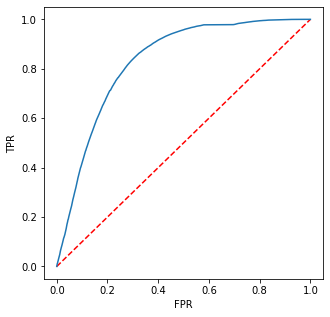

In [ ]:
#build a ROC curve
plt.figure(figsize=(5,5))
plt.plot([0, 1], [0, 1], 'r--')
plt.plot(best_model.summary.roc.select('FPR').collect(), \
         best_model.summary.roc.select('TPR').collect())
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

###Random Forest

In [ ]:
from time import time
t0 = time()

from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(featuresCol='word2vec', labelCol='label', impurity='gini')



#buit a paramiters grid for cross validattor
rf_paramGrid = ParamGridBuilder() \
      .addGrid(rf.maxDepth, [5])\
      .addGrid(rf.numTrees, [15])\
      .build()

#build CrossValidator
rf_crossval = CrossValidator(estimator = rf,
                          estimatorParamMaps=rf_paramGrid,
                          evaluator=evaluator,
                          numFolds=5)

#fit training data into crossvalidator
cv_rf_model = rf_crossval.fit(w2v_training_df)

#get best model
best_rf_model = cv_rf_model.bestModel

#transform training and test data
rf_prediction_training = best_rf_model.transform(w2v_training_df)
rf_prediction_test = best_rf_model.transform(w2v_test_df)

tt = time()- t0
print('Trining use {} seconds.'.format(tt))
#get trainning summary
rf_trainingSummary = beat_rf_model.summary

In [ ]:
print("Prediction Result Summary For Random Forest Model:  ")
get_evaluation_result(rf_prediction_test)

Prediction Result Summary For Random Forest Model:  
True Positives: 4351
False Positives: 82799
True Negatives: 891159
False Negatives: 3681
Test Accuracy: 0.9119339300807544
Test Precision: 0.04992541594951234
Test Recall: 0.5417081673306773
Test AUC of ROC: 0.8780404451465091


In [ ]:
rf_accuracy_train = rf_prediction_training.filter(rf_prediction_training.label == rf_prediction_training.prediction).count()/float(rf_prediction_training.count())
rf_accuracy_test = rf_prediction_test.filter(rf_prediction_test.label == rf_prediction_test.prediction).count()/float(rf_prediction_test.count())

print('Training set areaUnderROC: ' + str(evaluator.evaluate(rf_prediction_training)))
print('Testing set areaUnderROC ' + str(evaluator.evaluate(rf_prediction_test)))
print('Training set accuracy: ' + str(rf_accuracy_train))
print('Testing set accuracy ' + str(rf_accuracy_test))

Training set areaUnderROC: 0.8766808594258566
Testing set areaUnderROC 0.8780404451465091
Training set accuracy: 0.7894714935328456
Testing set accuracy 0.9119339300807544


##LDA

In [ ]:
clean_test_df.show()

+--------------------+---------+--------------------+-------+------+-----+--------------------+--------------------+--------------------+
|        creator_name|   userid|             comment|dog_cat|no_pet|label|               words|            filtered|        stem_comment|
+--------------------+---------+--------------------+-------+------+-----+--------------------+--------------------+--------------------+
|       Brian Barczyk| 124380.0|Arty will get bet...|   true| false|  1.0|[arty, will, get,...|[arty, get, bette...|[arti, get, bette...|
|       Brian Barczyk| 410371.0|that happend to m...|   true| false|  1.0|[that, happend, t...|      [happend, dog]|      [happend, dog]|
|       Brian Barczyk| 458191.0|I totally know ho...|   true| false|  1.0|[i, totally, know...|[totally, know, f...|[total, know, fee...|
|       Brian Barczyk| 894048.0|I feel bad for yo...|   true| false|  1.0|[i, feel, bad, fo...|[feel, bad, dog, ...|[feel, bad, dog, ...|
|       Cat Man Chris| 698142.0|my

##Part3: Get Insights From Dog And Cat Owner's Comments

**Create an datafram only contains cat and dog owners (labeled and predicted 1), and we will build an LDA model to find the laten topic in their comments.**

In [ ]:
from pyspark.mllib.linalg import Vector, Vectors
from pyspark.ml.clustering import LDA
from pyspark.ml.feature import CountVectorizer, CountVectorizerModel, IDF


#create a cat and dog dataframe with col userid and filtered
pet_train = clean_training_df.filter(col('label')==1.0).select('userid', 'stem_comment')
pet_test = clean_test_df.filter(col('label')==1.0).select('userid', 'stem_comment')
pet_owner_df = pet_train.union(pet_test).dropDuplicates()
pet_owner_df.cache()

#TF
cv = CountVectorizer(inputCol="stem_comment", outputCol="raw_features",
                     vocabSize=5000,
                     minTF=1, # minium number of times a word must appear in a document
                     minDF=4) # minimun number of documents a word must appear in

countVectorModel = cv.fit(pet_owner_df)
result_cv = countVectorModel.transform(pet_owner_df)

#IDF
idf = IDF(inputCol='raw_features', outputCol='tf-idf')
idfModel = idf.fit(result_cv)
result_tfidf = idfModel.transform(result_cv).cache()

print(len(result_tfidf.vocabulary))  # how many documents, vocab size

In [ ]:
#Vuild a dataframe to fit LDA model
corpus = result_tfidf.select(['userid','tf-idf']).cache()

#Build a LDA model
from time import time
t0 = time()

numTopics = 10 # number of topics

lda = LDA(k = numTopics, featuresCol='tf-idf',
          maxIter = 50, # number of iterations
          optimizer='em')

ldaModel = lda.fit(corpus)

t1 = time()-t0
print('Train LDA model use %s seconds.'%round(t1, 3))

+---------+--------------------+
|   userid|              tf-idf|
+---------+--------------------+
|1707102.0|(5000,[1,6,172,10...|
| 395102.0|(5000,[1,4,235],[...|
| 568812.0|(5000,[1,15,23,30...|
|  10476.0|(5000,[0,27,43,47...|
|  18153.0|(5000,[1,3,40,100...|
|1442087.0|(5000,[0,1,3,12,1...|
| 624757.0|        (5000,[],[])|
|1468609.0|(5000,[1,2,45,153...|
|1218281.0|(5000,[1,2,5,12,1...|
|  76676.0|(5000,[0,5,23,40,...|
|1276471.0|(5000,[1,51,357,9...|
|1254021.0|(5000,[1,2,11,19,...|
| 325704.0|(5000,[0,113],[0....|
|2343347.0|(5000,[9,83,183,4...|
| 328575.0|(5000,[1,4,877,97...|
| 169047.0|(5000,[15,17,59,8...|
|2349236.0|(5000,[0,42,264,2...|
|2360959.0|(5000,[0,797],[0....|
|2290206.0|(5000,[0,50,107,1...|
|1254944.0|(5000,[4,10,19,53...|
+---------+--------------------+
only showing top 20 rows



**Notes: take about 45 mins to train.

**Elvaluate LDA Model With loglikehood And logperplexity Metircs**

In [ ]:
#Evaluate the LDA model with metirc loglikelihood and logPerplexity
#ll = ldaModel.logLikelihood(corpus)
lp = ldaModel.logPerplexity(corpus)
print('The lower bound on the log likelihood of the entire corpus: ', ll)
print('The upper bound on perplecity: ', lp)

The lower bound on the log likelihood of the entire corpus:  -21439828.798633683
The upper bound on perplecity:  7.932862966385386


In [ ]:
# Print topics and top-weighted terms
topicwords = 20
topics = ldaModel.describeTopics(topicwords)
print('The topics described by their top-weighted terms: ')
topics.show(truncate=False)

The topics described by their top-weighted terms: 
+-----+--------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|topic|termIndices                                                                                 |termWeights                                                                                                                                                                                                                                                                                                     

In [ ]:
vocabArray = countVectorModel.vocabulary
print(len(vocabArray))

5000


In [ ]:
ListOfIndexToWords = udf(lambda wl: list([vocabArray[w] for w in wl]))
print(ListOfIndexToWords)

<function <lambda> at 0x7fcde315a620>


In [ ]:
topics.select('topic', ListOfIndexToWords(topics.termIndices).alias('words')).show(truncate=False, n=numTopics)

+-----+-----------------------------------------------------------------------------------------------------------------------------------+
|topic|words                                                                                                                              |
+-----+-----------------------------------------------------------------------------------------------------------------------------------+
|0    |[cat, kitti, food, like, talk, think, video, one, make, meow, snake, realli, sound, get, kind, ball, say, also, that, look]        |
|1    |[play, lol, hous, dog, sit, toy, bark, outsid, let, run, get, ran, around, like, crazi, puppi, cat, bite, lay, away]               |
|2    |[day, got, cri, still, mom, guy, didnt, happen, heart, dad, die, went, came, said, hard, fuck, last, one, week, home]              |
|3    |[cat, sleep, start, bed, face, watch, night, jump, wait, room, come, huski, head, see, like, hug, gonna, german, hear, door]       |
|4    |[anim, peopl,